# Meter Reading

<img src='https://user-images.githubusercontent.com/71766106/229337163-9b679eca-3fdc-4c76-bb86-9dede5458420.png' width=50%>

Since now we have both meter detector and segmentor we can now use them to build a complete pipeline to read meter.

This will include :
* Preprocessing
* Detection
* Segmentation
* Postprocessing
* Visualize result

In [ ]:
import tensorflow as tf
import os
from pathlib import Path as path
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
# download detector and segmentor weights
!gdown 12opeMR5xRqyyfLx3IubEiXVOYhSHcU2-
!gdown 12whEYgejocWBb8gQqVwPJkgH_jPvLofy

### Downloading test meter Dataset
Again we will use PP's meter dataset to test on images not been used in training of any model

In [ ]:
det = 'https://bj.bcebos.com/paddlex/examples/meter_reader/datasets/meter_det.tar.gz'
seg = 'https://bj.bcebos.com/paddlex/examples/meter_reader/datasets/meter_seg.tar.gz'
test = 'https://bj.bcebos.com/paddlex/examples/meter_reader/datasets/meter_test.tar.gz'

if ('meter_seg' not in os.listdir()):
    for i in [test]:
        !wget $i
        dir_name = i.split('/')[-1]
        !tar -xf $dir_name
else:
    print('Directory already exist')

### Defining Utility Functions
These function are from [Openvino's 203 notebook](https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/203-meter-reader/203-meter-reader.ipynb), they will help up to detect scale and pointer and extract readings from segmentation masks.

In [ ]:
# ALL THE FUNCTIONS DEFINED IN THIS CELL ARE FROM OpenVINO's 203-meter-reader.ipynb

METER_SHAPE = [512, 512] 
CIRCLE_CENTER = [256, 256] 
CIRCLE_RADIUS = 250
PI = math.pi
RECTANGLE_HEIGHT = 100
RECTANGLE_WIDTH = 785
TYPE_THRESHOLD = 40

METER_CONFIG = [{
    'scale_interval_value': 25.0 / 50.0,
    'range': 25.0,
    'unit': "(MPa)"
}, {
    'scale_interval_value': 1.6 / 32.0,
    'range': 1.6,
    'unit': "(MPa)"
}]

SEG_LABEL = {'background': 0, 'pointer': 1, 'scale': 2}

def roi_crop(image, results, scale_x, scale_y):
    """
    Crop the area of detected meter of original image

    Param：
        img (np.array)：original image。
        det_results (list[dict]): detection results
        scale_x (float): the scale value in x axis
        scale_y (float): the scale value in y axis

    Retuns：
        roi_imgs (list[np.array]): the list of meter images
        loc (list[int]): the list of meter locations
    
    """
    roi_imgs = []
    loc = []
    for result in results:
        bbox = result
        ymin, xmin, ymax, xmax = [int(bbox[0] * scale_x), int(bbox[1] * scale_y), int(bbox[2] * scale_x), int(bbox[3] * scale_y)]
        sub_img = image[ymin:(ymax + 1), xmin:(xmax + 1), :]
        roi_imgs.append(sub_img)
        loc.append([xmin, ymin, xmax, ymax])
    return roi_imgs, loc

def roi_process(input_images, target_size, interp=cv2.INTER_LINEAR):
    """
    Prepare the roi image of detection results data
    Preprocessing the input data for segmentation task

    Param：
        input_images (list[np.array])：the list of meter images
        target_size (list|tuple)： height and width of resized image， e.g [heigh,width]
        interp (int)：the interp method for image reszing

    Retuns：
        img_list (list[np.array])：the list of processed images
        resize_img (list[np.array]): for visualization
    
    """
    img_list = list()
    resize_list = list()
    for img in input_images:
        img_shape = img.shape
        scale_x = float(target_size[1]) / float(img_shape[1])
        scale_y = float(target_size[0]) / float(img_shape[0])
        resize_img = cv2.resize(img, None, None, fx=scale_x, fy=scale_y, interpolation=interp)
        resize_list.append(resize_img)
        resize_img = resize_img.transpose(2, 0, 1) / 255
        img_mean = np.array([0.5, 0.5, 0.5]).reshape((3, 1, 1))
        img_std = np.array([0.5, 0.5, 0.5]).reshape((3, 1, 1))
        resize_img -= img_mean
        resize_img /= img_std
        img_list.append(resize_img)
    return img_list, resize_list


def erode(seg_results, erode_kernel):
    """
    Erode the segmentation result to get the more clear instance of pointer and scale

    Param：
        seg_results (list[dict])：segmentation results
        erode_kernel (int): size of erode_kernel

    Return：
        eroded_results (list[dict])： the lab map of eroded_results
        
    """
    kernel = np.ones((erode_kernel, erode_kernel), np.uint8)
    eroded_results = seg_results
    for i in range(len(seg_results)):
        eroded_results[i] = cv2.erode(seg_results[i].astype(np.uint8), kernel)
    return eroded_results


def circle_to_rectangle(seg_results):
    """
    Switch the shape of label_map from circle to rectangle

    Param：
        seg_results (list[dict])：segmentation results

    Return：
        rectangle_meters (list[np.array])：the rectangle of label map

    """
    rectangle_meters = list()
    for i, seg_result in enumerate(seg_results):
        label_map = seg_result

        # The size of rectangle_meter is determined by RECTANGLE_HEIGHT and RECTANGLE_WIDTH
        rectangle_meter = np.zeros((RECTANGLE_HEIGHT, RECTANGLE_WIDTH), dtype=np.uint8)
        for row in range(RECTANGLE_HEIGHT):
            for col in range(RECTANGLE_WIDTH):
                theta = PI * 2 * (col + 1) / RECTANGLE_WIDTH
                
                # The radius of meter circle will be mapped to the height of rectangle image
                rho = CIRCLE_RADIUS - row - 1
                y = int(CIRCLE_CENTER[0] + rho * math.cos(theta) + 0.5)
                x = int(CIRCLE_CENTER[1] - rho * math.sin(theta) + 0.5)
                rectangle_meter[row, col] = label_map[y, x]
        rectangle_meters.append(rectangle_meter)
    return rectangle_meters


def rectangle_to_line(rectangle_meters):
    """
    Switch the dimension of rectangle label map from 2D to 1D

    Param：
        rectangle_meters (list[np.array])：2D rectangle OF label_map。

    Return：
        line_scales (list[np.array])： the list of scales value
        line_pointers (list[np.array])：the list of pointers value

    """
    line_scales = list()
    line_pointers = list()
    for rectangle_meter in rectangle_meters:
        height, width = rectangle_meter.shape[0:2]
        line_scale = np.zeros((width), dtype=np.uint8)
        line_pointer = np.zeros((width), dtype=np.uint8)
        for col in range(width):
            for row in range(height):
                if rectangle_meter[row, col] == SEG_LABEL['pointer']:
                    line_pointer[col] += 1
                elif rectangle_meter[row, col] == SEG_LABEL['scale']:
                    line_scale[col] += 1
        line_scales.append(line_scale)
        line_pointers.append(line_pointer)
    return line_scales, line_pointers


def mean_binarization(data_list):
    """
    Binarize the data

    Param：
        data_list (list[np.array])：input data

    Return：
        binaried_data_list (list[np.array])：output data。

    """
    batch_size = len(data_list)
    binaried_data_list = data_list
    for i in range(batch_size):
        mean_data = np.mean(data_list[i])
        width = data_list[i].shape[0]
        for col in range(width):
            if data_list[i][col] < mean_data:
                binaried_data_list[i][col] = 0
            else:
                binaried_data_list[i][col] = 1
    return binaried_data_list


def locate_scale(line_scales):
    """
    Find location of center of each scale

    Param：
        line_scales (list[np.array])：the list of binaried scales value

    Return：
        scale_locations (list[list])：location of each scale

    """
    batch_size = len(line_scales)
    scale_locations = list()
    for i in range(batch_size):
        line_scale = line_scales[i]
        width = line_scale.shape[0]
        find_start = False
        one_scale_start = 0
        one_scale_end = 0
        locations = list()
        for j in range(width - 1):
            if line_scale[j] > 0 and line_scale[j + 1] > 0:
                if not find_start:
                    one_scale_start = j
                    find_start = True
            if find_start:
                if line_scale[j] == 0 and line_scale[j + 1] == 0:
                    one_scale_end = j - 1
                    one_scale_location = (one_scale_start + one_scale_end) / 2
                    locations.append(one_scale_location)
                    one_scale_start = 0
                    one_scale_end = 0
                    find_start = False
        scale_locations.append(locations)
    return scale_locations


def locate_pointer(line_pointers):
    """
    Find location of center of pointer

    Param：
        line_scales (list[np.array])：the list of binaried pointer value

    Return：
        scale_locations (list[list])：location of pointer

    """
    batch_size = len(line_pointers)
    pointer_locations = list()
    for i in range(batch_size):
        line_pointer = line_pointers[i]
        find_start = False
        pointer_start = 0
        pointer_end = 0
        location = 0
        width = line_pointer.shape[0]
        for j in range(width - 1):
            if line_pointer[j] > 0 and line_pointer[j + 1] > 0:
                if not find_start:
                    pointer_start = j
                    find_start = True
            if find_start:
                if line_pointer[j] == 0 and line_pointer[j + 1] == 0 :
                    pointer_end = j - 1
                    location = (pointer_start + pointer_end) / 2
                    find_start = False
                    break
        pointer_locations.append(location)
    return pointer_locations


def get_relative_location(scale_locations, pointer_locations):
    """
    Match location of pointer and scales

    Param：
        scale_locations (list[list])：location of each scale
        pointer_locations (list[list])：location of pointer

    Return：
        pointed_scales (list[dict])： a list of dict with:
                                     'num_scales': total number of scales
                                     'pointed_scale': predicted number of scales
            
    """
    pointed_scales = list()
    for scale_location, pointer_location in zip(scale_locations,
                                                pointer_locations):
        num_scales = len(scale_location)
        pointed_scale = -1
        if num_scales > 0:
            for i in range(num_scales - 1):
                if scale_location[i] <= pointer_location < scale_location[i + 1]:
                    pointed_scale = i + (pointer_location - scale_location[i]) / (scale_location[i + 1] - scale_location[i] + 1e-05) + 1
        result = {'num_scales': num_scales, 'pointed_scale': pointed_scale}
        pointed_scales.append(result)
    return pointed_scales


def calculate_reading(pointed_scales):
    """
    Calculate the value of meter according to the type of meter

    Param：
        pointed_scales (list[list])：predicted number of scales

    Return：
        readings (list[float])： the list of values read from meter
            
    """
    readings = list()
    batch_size = len(pointed_scales)
    for i in range(batch_size):
        pointed_scale = pointed_scales[i]
        # find the type of meter according the total number of scales
        if pointed_scale['num_scales'] > TYPE_THRESHOLD:
            reading = pointed_scale['pointed_scale'] * METER_CONFIG[0]['scale_interval_value']
        else:
            reading = pointed_scale['pointed_scale'] * METER_CONFIG[1]['scale_interval_value']
        readings.append(reading)
    return readings

### Loading Model
The zip file contains models in TF's SavedModel format which will be loaded and then can be use directly/

In [ ]:
!unzip efficientdet_meter_detector.zip
!unzip segmentor_efficientnet.zip

In [ ]:
# Loading trained model {Traning is showed in segmentor.ipynb and detector.ipynb}

detector = tf.saved_model.load('inference_graph/saved_model') 

segmentor = tf.keras.models.load_model('saved_model')

In [ ]:
def plot_result(img,readings,bboxs):
    '''
    Parameters
        img (np.ndarray) : image
        readings (array) : reading of detected meters
        bboxs(np.ndarray): BBOXs of detected meters
    
    Returns
        img (np.ndarray) : image with BBOX and readings
    '''
    for i in range(len(readings)):
        reading = readings[i]
        if reading >= 0:
            ymin,xmin,ymax,xmax = bboxs[i]

            img = cv2.rectangle(img,
                                (xmin,ymin),
                                (xmax,ymax),
                                (255, 51, 204),
                                3)
            img = cv2.putText(img,
                            f'{reading:.3f}',
                            (xmin,ymin-5),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            2,
                            (255,0,255),
                            6)
    return img

In [ ]:
def pipeline(frame):
    '''
    Complete pipeline

    Image --> Detection --> Cropping --> Semantic-Segmentation --> Reading --> Plotting
    '''


    # Getting Detection BBOXs
    frame = cv2.resize(frame,(1920,1080),cv2.INTER_AREA)
    prediction = detector(frame.reshape(1,1080,1920,3))
    result_ratio = prediction['detection_boxes'].numpy()[0]
    scores = prediction['detection_scores'].numpy()[0]
    selected_rr = []

    for i in range(len(scores)):
        if scores[i]>0.5:
            selected_rr.append(result_ratio[i])
        else:
            break

    results = np.multiply(np.array(selected_rr),np.array([1082,1920,1082,1920])).astype(np.int64)

    # Cropping Meters
    roi_imgs,loc = roi_crop(frame,results,1,1)
    
    # Preprocess uneven cropped imgs to 256,256
    crop_img = []
    for roi_img in roi_imgs:
        resized = cv2.resize(roi_img,(256,256),cv2.INTER_AREA)
        crop_img.append(resized)

    if len(crop_img) > 0:
        # Getting Segmentation Maps
        pred_seg = segmentor.predict(np.array(crop_img),verbose=0)
        processed_seg = []
        for i in pred_seg:
            processed_seg.append(cv2.resize(i,(512,512),cv2.INTER_AREA))
        pred = np.argmax(processed_seg,axis=3)

        # Getting Reading from predicted Maps
        pred = erode(pred,2)
        rectangle_meters = circle_to_rectangle(pred)
        line_scales, line_pointers = rectangle_to_line(rectangle_meters)
        binaried_scales = mean_binarization(line_scales)
        binaried_pointers = mean_binarization(line_pointers)
        scale_locations = locate_scale(binaried_scales)
        pointer_locations = locate_pointer(binaried_pointers)
        pointed_scales = get_relative_location(scale_locations, pointer_locations)
        meter_readings = calculate_reading(pointed_scales)

        # Plotting reading and BBOXs on image
        plotted_img = plot_result(frame,meter_readings,results)
    
    else:
        plotted_img = frame
    return plotted_img

In [ ]:
img = cv2.imread('/content/meter_test/20190822_93.jpg')

In [ ]:
l = pipeline(img)

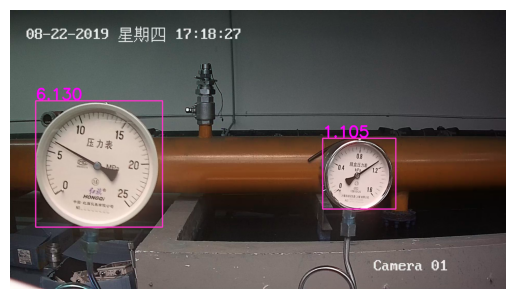

In [ ]:
plt.imshow(l);plt.axis(False);plt.show()